# ML_25M Classic ML

In [2]:
import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

seed = 42
np.random.seed(seed)
random.seed(seed)
df = pd.read_csv('dataset.csv')


## Data Preprocessing

In [3]:
X = df.drop('rating', axis=1)
Y = df['rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

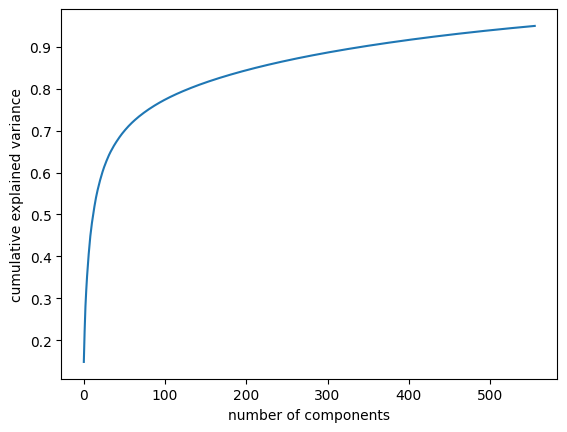

556


In [4]:
# Scree plot
pca = PCA(.95)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

print(pca.n_components_)

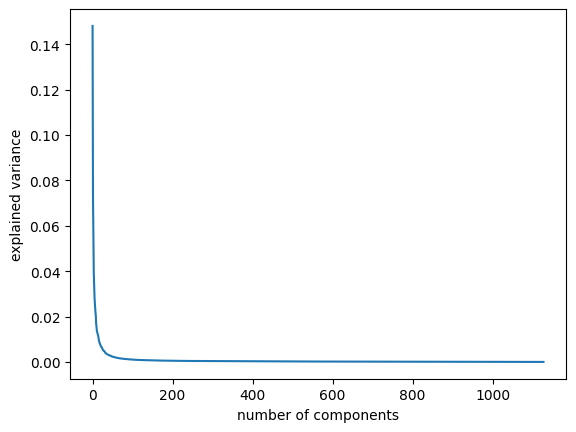

1128


In [5]:
# Kaiser criterion
pca = PCA()
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

print(pca.n_components_)

# PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [6]:
# PCA
pca = PCA(n_components=556)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [7]:

print(f'Number of training samples: {X_train.shape}')
print(f'Number of testing samples: {X_test.shape}')
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])


Number of training samples: (11052, 556)
Number of testing samples: (2764, 556)


# Models

## Support Vector Regression

In [11]:
# SVR with Bayesian Optimization
def svr_cv(C, gamma, epsilon):
    val = cross_val_score(SVR(C=C, gamma=gamma, epsilon=epsilon), X_train, Y_train, scoring="neg_mean_squared_error", cv=5)
    return np.mean(val)

# Bounded region of parameter space
pbounds = {'C': (0.1, 100), 'gamma': (0.0001, 0.1), 'epsilon': (0.1, 1)}

optimizer = BayesianOptimization(
    f=svr_cv,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(
    init_points=2,
    n_iter=10,
)   

print(optimizer.max{'params'})

# SVR
svr = SVR(C=optimizer.max['params']['C'], gamma=optimizer.max['params']['gamma'], epsilon=optimizer.max['params']['epsilon'])
svr.fit(X_train, Y_train)
Y_pred = svr.predict(X_test)

# Evaluate the model
mse = np.mean((Y_pred - Y_test)**2)
rmse = np.sqrt(mse)
r2 = svr.score(X_test, Y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

results = df.concat([results, pd.DataFrame({'Model': 'SVR', 'MSE': mse, 'RMSE': rmse, 'R2': r2}, index=[0])], ignore_index=True)

|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
| 1         | -0.1435   | 41.76     | 0.7483    | 0.0001114 |
| 2         | -0.0106   | 30.3      | 0.2321    | 0.009325  |
| 3         | -0.00669  | 30.47     | 0.1381    | 0.005034  |
| 4         | -0.2494   | 34.26     | 0.9743    | 0.04183   |
| 5         | -0.01552  | 26.49     | 0.1415    | 0.09064   |
| 6         | -0.006212 | 23.43     | 0.1       | 0.02134   |
| 7         | -0.2065   | 20.14     | 0.9147    | 0.07701   |
| 8         | -0.265    | 24.92     | 0.9929    | 0.03045   |
| 9         | -0.007206 | 22.5      | 0.1       | 0.0001    |
| 10        | -0.01337  | 27.77     | 0.1       | 0.0913    |
| 11        | -0.2442   | 31.36     | 1.0       | 0.1       |
| 12        | -0.2605   | 27.28     | 0.9664    | 0.01531   |
{'target': -0.006212271951108905, 'params': {'C': 23.434195528940055, 'epsilon': 0.1, 'gamma': 0.021337254289072665}}
MSE: 0.0059638

/var/folders/b3/wwdp9x6d2_3fvz33_v4d_k_80000gn/T/ipykernel_14169/1737303031.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'SVR', 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)


## Random Forest Regressor

In [9]:
# Random Forest Regressor

best_n = 0
best_mse = float('inf')

for n in range(50, 100):
    print("Number of trees: {}".format(n), end='\r')
    rfr = RandomForestRegressor(n_estimators=n, random_state=seed)
    rfr.fit(X_train, Y_train)
    rfr_pred = rfr.predict(X_test)
    mse = np.mean((rfr_pred - Y_test) ** 2)
    if mse < best_mse:
        best_mse = mse
        best_n = n

print(f'\n\nBest number of trees: {best_n}')
print(f'Best MSE: {best_mse}')

rfr = RandomForestRegressor(n_estimators=best_n, random_state=seed)
rfr.fit(X_train, Y_train)
rfr_pred = rfr.predict(X_test)

# MSE and RMSE
mse = np.mean((rfr_pred - Y_test) ** 2)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# R2
r2 = rfr.score(X_test, Y_test)
print(f'R2: {r2}')

results = df.concat([results, pd.DataFrame({'Model': 'Random Forest Regressor', 'MSE': mse, 'RMSE': rmse, 'R2': r2}, index=[0])], ignore_index=True)

Number of trees: 99'
Best number of trees: 67
Best MSE: 0.03488640313780709
MSE: 0.035726407210077055
RMSE: 0.1890143042472634
R2: 0.838827821587694


/var/folders/b3/wwdp9x6d2_3fvz33_v4d_k_80000gn/T/ipykernel_14169/2403044734.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': 'Random Forest Regressor', 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)


## Logistic Classifier

In [ ]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, Y_train)

# accuracy
accuracy = logistic_classifier.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame(
    {'Model': 'Logistic Regression', 'Accuracy': accuracy}, index=[0])], ignore_index=True)


Accuracy: 0.8324891461649783


/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Naive Bayes

In [ ]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, Y_train)

# accuracy
accuracy = naive_bayes.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame(
    {'Model': 'Naive Bayes', 'Accuracy': accuracy}, index=[0])], ignore_index=True)


Accuracy: 0.5021707670043415


## SVM

In [ ]:
svm = SVC()
svm.fit(X_train, Y_train)

# accuracy
accuracy = svm.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame(
    {'Model': 'SVM', 'Accuracy': accuracy}, index=[0])], ignore_index=True)


Accuracy: 0.847684515195369
